In [1]:
import csv
import os
import random

import cv2
import dask.array as da
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [14]:
def train_test_curves(data):
    fig = plt.figure()
    ax1 = fig.add_subplot(221)

    ax1.plot(data["acc"])
    ax1.plot(data["val_acc"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["train","test"])

    ax2 = fig.add_subplot(222)

    ax2.plot(data["loss"])
    ax2.plot(data["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["train","test"])
    
    return ax1, ax2

In [2]:
def img_path(subdir_path, img_path):
    imgdir_path = os.path.join(subdir_path, "IMG")
    img_path = os.path.join(imgdir_path, img_path)
    return img_path

def read_data(root_folder="track1_data", subfolder=None):
    subdir_path = os.path.join(root_folder, subfolder)
    
    driving_log = pd.read_csv(os.path.join(subdir_path, "driving_log.csv"), header=None, skiprows=[0])
    driving_log.columns = ["center_img","left_img","right_img","steering_angle","throttle","break","speed"]
    
    driving_log["center_img"] = driving_log["center_img"].apply(lambda v: img_path(subdir_path, v.split("/")[-1]))
    driving_log["left_img"] = driving_log["left_img"].apply(lambda v: img_path(subdir_path, v.split("/")[-1]))
    driving_log["right_img"] = driving_log["right_img"].apply(lambda v: img_path(subdir_path, v.split("/")[-1]))    
    
    return driving_log

In [3]:
track1_front_center = read_data("track1_data","training_data_center_front")
track1_front_left = read_data("track1_data","training_data_left_front")
track1_front_right = read_data("track1_data","training_data_right_front")

track1_back_center = read_data("track1_data","training_data_center_back")
track1_back_left = read_data("track1_data","training_data_left_back")
track1_back_right = read_data("track1_data","training_data_right_back")

track1_front_recovery1 = read_data("track1_data","training_data_recovery_front_1")
track1_front_recovery2 = read_data("track1_data","training_data_recovery_front_2")

In [4]:
data = pd.concat([track1_front_center,track1_front_left,track1_front_right, \
                  track1_back_center,track1_back_left,track1_back_right])

# clear from memory
del track1_front_center
del track1_front_left
del track1_front_right
del track1_back_center
del track1_back_left
del track1_back_right

In [5]:
train_data, validation_data = train_test_split(data, test_size=0.3)
del data

In [6]:
train_data.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
2151,track1_data/training_data_left_back/IMG/center...,track1_data/training_data_left_back/IMG/left_2...,track1_data/training_data_left_back/IMG/right_...,0.0,0.260385,0.0,14.201500
271,track1_data/training_data_center_front/IMG/cen...,track1_data/training_data_center_front/IMG/lef...,track1_data/training_data_center_front/IMG/rig...,0.0,0.152622,0.0,10.824900
1727,track1_data/training_data_right_front/IMG/cent...,track1_data/training_data_right_front/IMG/left...,track1_data/training_data_right_front/IMG/righ...,0.0,0.000000,0.0,12.536770
10423,track1_data/training_data_center_front/IMG/cen...,track1_data/training_data_center_front/IMG/lef...,track1_data/training_data_center_front/IMG/rig...,0.0,0.000000,0.0,11.502320
2922,track1_data/training_data_center_front/IMG/cen...,track1_data/training_data_center_front/IMG/lef...,track1_data/training_data_center_front/IMG/rig...,0.0,0.000000,0.0,7.923998


In [7]:
train_data.shape, validation_data.shape

((19354, 7), (8295, 7))

In [8]:
correction = 0.2

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
        

            images = []
            angles = []
            
            
            for index, batch_sample in batch_samples.iterrows():
                img_path = batch_sample["center_img"]
                steering_angle = batch_sample["steering_angle"]
                
                img_loaded = cv2.imread(img_path)
                images.append(img_loaded)
                angles.append(steering_angle)
                images.append(cv2.flip(img_loaded, 1))
                angles.append(steering_angle*-1.0)
                
                
                img_path = batch_sample["left_img"]
                steering_angle = batch_sample["steering_angle"]
                
                img_loaded = cv2.imread(img_path)
                steering_angle = steering_angle + correction
                images.append(img_loaded)
                angles.append(steering_angle)
                images.append(cv2.flip(img_loaded, 1))
                angles.append(steering_angle*-1.0)
                
                img_path = batch_sample["right_img"]
                steering_angle = batch_sample["steering_angle"]
                
                img_loaded = cv2.imread(img_path)
                steering_angle = steering_angle - correction
                images.append(img_loaded)
                angles.append(steering_angle)
                images.append(cv2.flip(img_loaded, 1))
                angles.append(steering_angle*-1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [9]:
train_generator = generator(train_data, batch_size=10) # here batch_size=10 is actually 10 * 3 * 2 because we are loading center, left and right images
validation_generator = generator(validation_data, batch_size=10)

### Model

In [10]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# crop top 70px, bottom 25px because we have bad data on top like trees, sky etc and 
#                                                        bottom has hood of the car
# Also - 1 px from left of the image and 1 px on the right of the image.
model.add(Cropping2D(cropping=((70,25),(1,1))))
model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

checkpoint = ModelCheckpoint('behavioral_cloning/model_track1.h5', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor = 'val_loss', mode='auto', patience=5)

# history = model.fit(augmented_images, augmented_measurements, validation_split=0.20, shuffle=True, epochs=25,
#                     callbacks=[checkpoint, early_stopping])

# model.save("model.h5")
fit_history = model.fit_generator(train_generator, steps_per_epoch= \
            len(train_data), validation_data=validation_generator, \
            nb_val_samples=len(validation_data), epochs=50, \
            callbacks=[checkpoint, early_stopping], shuffle=True)

Epoch 1/50
19354/19354 [==============================] - 1383s 71ms/step - loss: 0.0208 - acc: 0.2639 - val_loss: 0.0237 - val_acc: 0.2637
Epoch 2/50
19354/19354 [==============================] - 1367s 71ms/step - loss: 0.0116 - acc: 0.2642 - val_loss: 0.0271 - val_acc: 0.2631
Epoch 3/50
19354/19354 [==============================] - 1377s 71ms/step - loss: 0.0080 - acc: 0.2642 - val_loss: 0.0267 - val_acc: 0.2631
Epoch 4/50
19354/19354 [==============================] - 1364s 70ms/step - loss: 0.0062 - acc: 0.2642 - val_loss: 0.0268 - val_acc: 0.2634
Epoch 5/50
19354/19354 [==============================] - 1364s 70ms/step - loss: 0.0052 - acc: 0.2642 - val_loss: 0.0284 - val_acc: 0.2630
Epoch 6/50
19354/19354 [==============================] - 1366s 71ms/step - loss: 0.0045 - acc: 0.2642 - val_loss: 0.0298 - val_acc: 0.2627


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb886f53c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb886be358>)

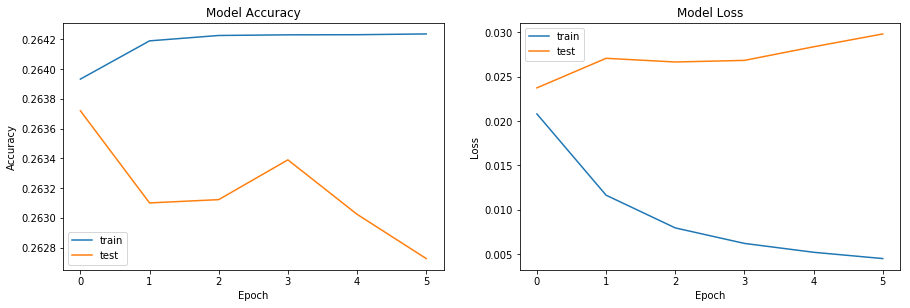

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)  # width, height
train_test_curves(fit_history.history)

In [11]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# crop top 70px, bottom 25px because we have bad data on top like trees, sky etc and 
#                                                        bottom has hood of the car
# Also - 1 px from left of the image and 1 px on the right of the image.
model.add(Cropping2D(cropping=((70,25),(1,1))))
model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

checkpoint = ModelCheckpoint('behavioral_cloning/model_track1_dropout.h5', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor = 'val_loss', mode='auto', patience=5)

# history = model.fit(augmented_images, augmented_measurements, validation_split=0.20, shuffle=True, epochs=25,
#                     callbacks=[checkpoint, early_stopping])

# model.save("model.h5")
fit_history_dropout = model.fit_generator(train_generator, steps_per_epoch= \
            len(train_data), validation_data=validation_generator, \
            nb_val_samples=len(validation_data), epochs=50, callbacks=[checkpoint, early_stopping])

Epoch 1/50
19354/19354 [==============================] - 1346s 70ms/step - loss: 0.0212 - acc: 0.2639 - val_loss: 0.0231 - val_acc: 0.2635
Epoch 2/50
19354/19354 [==============================] - 1361s 70ms/step - loss: 0.0119 - acc: 0.2641 - val_loss: 0.0289 - val_acc: 0.2620
Epoch 3/50
19354/19354 [==============================] - 1357s 70ms/step - loss: 0.0082 - acc: 0.2642 - val_loss: 0.0293 - val_acc: 0.2623
Epoch 4/50
19354/19354 [==============================] - 1349s 70ms/step - loss: 0.0065 - acc: 0.2642 - val_loss: 0.0265 - val_acc: 0.2632
Epoch 5/50
19354/19354 [==============================] - 1350s 70ms/step - loss: 0.0055 - acc: 0.2642 - val_loss: 0.0270 - val_acc: 0.2626
Epoch 6/50
19354/19354 [==============================] - 1356s 70ms/step - loss: 0.0049 - acc: 0.2642 - val_loss: 0.0260 - val_acc: 0.2629


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb88693a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb807d9438>)

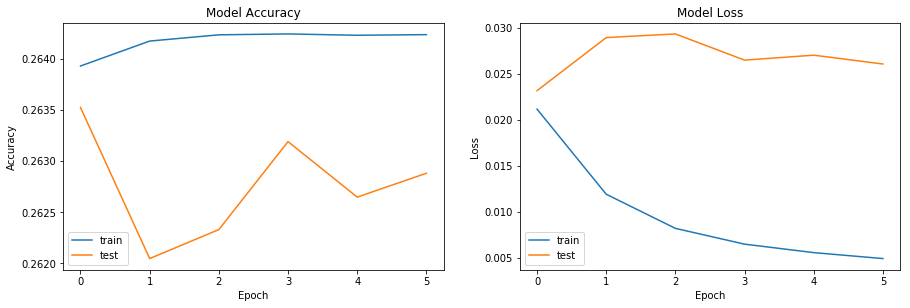

In [21]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)  # width, height
train_test_curves(fit_history_dropout.history)

In [12]:
optimizer_adam = Adam(lr=0.0001)


model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# crop top 70px, bottom 25px because we have bad data on top like trees, sky etc and 
#                                                        bottom has hood of the car
# Also - 1 px from left of the image and 1 px on the right of the image.
model.add(Cropping2D(cropping=((70,25),(1,1))))
model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
# model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))



model.compile(loss="mse", optimizer=optimizer_adam, metrics=["accuracy"])

checkpoint = ModelCheckpoint('behavioral_cloning/model_track1_customadam.h5', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor = 'val_loss', mode='auto', patience=5)

# history = model.fit(augmented_images, augmented_measurements, validation_split=0.20, shuffle=True, epochs=25,
#                     callbacks=[checkpoint, early_stopping])

# model.save("model.h5")
fit_history_custom_adam = model.fit_generator(train_generator, steps_per_epoch= \
            len(train_data), validation_data=validation_generator, \
            nb_val_samples=len(validation_data), epochs=50, callbacks=[checkpoint, early_stopping])

Epoch 1/50
19354/19354 [==============================] - 1356s 70ms/step - loss: 0.0220 - acc: 0.2639 - val_loss: 0.0290 - val_acc: 0.2630
Epoch 2/50
19354/19354 [==============================] - 1353s 70ms/step - loss: 0.0116 - acc: 0.2642 - val_loss: 0.0365 - val_acc: 0.2616
Epoch 3/50
19354/19354 [==============================] - 1355s 70ms/step - loss: 0.0075 - acc: 0.2642 - val_loss: 0.0386 - val_acc: 0.2617
Epoch 4/50
19354/19354 [==============================] - 1346s 70ms/step - loss: 0.0059 - acc: 0.2642 - val_loss: 0.0373 - val_acc: 0.2622
Epoch 5/50
19354/19354 [==============================] - 1355s 70ms/step - loss: 0.0050 - acc: 0.2642 - val_loss: 0.0376 - val_acc: 0.2622
Epoch 6/50
19354/19354 [==============================] - 1352s 70ms/step - loss: 0.0043 - acc: 0.2642 - val_loss: 0.0423 - val_acc: 0.2617


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb80766da0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb8071c550>)

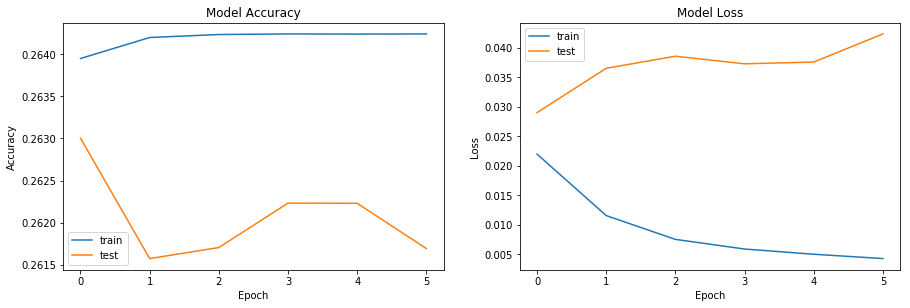

In [22]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)  # width, height
train_test_curves(fit_history_custom_adam.history)